In [31]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from PIL import Image
import os
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt

In [32]:
# Data Loading
DATA_PATH = "data/"

# Data & Augmentation
IMAGE_SIZE = 64
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Model
LATENT_SIZE = 128
MODEL_VERSION = "v1"
OLD_MODEL_EXISTS = False

# Training
NUM_IMAGES_TO_USE = 1000
START_INDEX = 0
BATCH_SIZE = 100
NUM_EPOCHS = 200
LEARNING_RATE = 0.0002

# Saving/Loading Model
MODEL_PATH = "model/" + MODEL_VERSION + "/"
SAMPLE_DIR = "generated/" + MODEL_VERSION + "/"

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

Using device cpu


In [34]:
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(SAMPLE_DIR, exist_ok=True)

In [35]:
def pil_loader_rgba(path: str) -> Image.Image:
    with open(path, 'rb') as f:
        img = Image.open(f)
        background = Image.new("RGBA", img.size, "WHITE")
        alphaComposite = Image.alpha_composite(background, img)
        result = alphaComposite.convert("RGB")
        return result

In [36]:
real_dataset = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=T.Compose([T.Resize(IMAGE_SIZE), 
T.CenterCrop(IMAGE_SIZE),
T.ToTensor(),
T.Normalize(*STATS)]))

real_dataset = Subset(real_dataset, range(NUM_IMAGES_TO_USE))

real_dataloader = DataLoader(real_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
def denormalize(img_tensors):
    return img_tensors *  STATS[1][0] + STATS[0][0]

def show_images(images, nmax=16):
    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denormalize(images.detach()[:nmax]), nrow=8).permute(1,2,0))
    plt.show()

def show_batch(dl, nmax=16):
    for i, (images, _) in enumerate(dl):
        print(images.shape)
        show_images(images, nmax)
        break

torch.Size([100, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

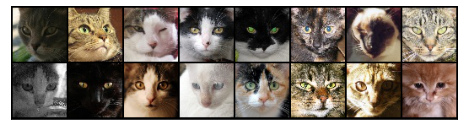

In [38]:
show_batch(real_dataloader)

In [39]:
discriminator = nn.Sequential(
    # in:  3 x 64 x 64

    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # 64 x 32 x 32

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # 128 x 16 x 16

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # 256 x 8 x 8

    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # 512 x 4 x 4

    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    # 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
).to(device)

In [40]:
generator = nn.Sequential(
    # in: LATENT_SIZE x 1 x 1

    nn.ConvTranspose2d(in_channels=LATENT_SIZE, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # 512 x 4 x 4

    nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # 256 x 8 x 8

    nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # 128 x 16 x 16

    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # 64 x 32 x 32

    nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    # 3 x 64 x 64
    nn.Tanh()
).to(device)

torch.Size([100, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

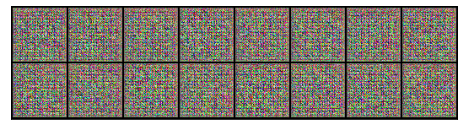

In [41]:
xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [42]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score

In [43]:
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(BATCH_SIZE, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    opt_g.step()

    return loss.item()

In [44]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = "generated-image-{0:0=4d}.png".format(index)
    save_image(denormalize(fake_images), os.path.join(SAMPLE_DIR, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show and (index % 10 == 0):
       show_images(fake_images)

Saving generated-image-0000.png


<Figure size 432x288 with 0 Axes>

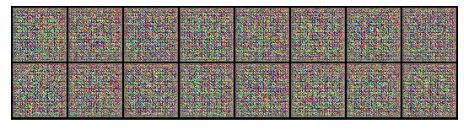

In [45]:
fixed_latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
save_samples(0, fixed_latent)

In [46]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999)) 

if (OLD_MODEL_EXISTS):
    discriminator.load_state_dict(torch.load(MODEL_PATH + "discriminator.pt"))
    generator.load_state_dict(torch.load(MODEL_PATH + "generator.pt"))

for epoch in range(NUM_EPOCHS):
    num_batches = len(real_dataloader)
    
    for batch_number, (real_images, _) in enumerate(real_dataloader):
        loss_d, _, _ = train_discriminator(real_images, opt_d)
        loss_g = train_generator(opt_g)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{batch_number+1}/{num_batches}], loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f}")
        
    save_samples(epoch+1+START_INDEX, fixed_latent, show=True)
    torch.save(discriminator.state_dict(), MODEL_PATH + "discriminator.pt")
    torch.save(generator.state_dict(), MODEL_PATH + "generator.pt")


Epoch [1/200], Batch [1/10], loss_g: 2.7126, loss_d: 1.4703


In [ ]:
torch.save(discriminator.state_dict(), MODEL_PATH + "discriminator.pt")
torch.save(generator.state_dict(), MODEL_PATH + "generator.pt")

In [ ]:
discriminator.load_state_dict(torch.load(MODEL_PATH + "discriminator.pt"))
generator.load_state_dict(torch.load(MODEL_PATH + "generator.pt"))

<All keys matched successfully>